In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import exp
import os, time

In [2]:
def getFilesFrom(baseDir):
    files = []
    
    for file in os.listdir(baseDir):
        if '.csv' not in file:
            continue

        filePath = os.path.join(baseDir, file) if baseDir else file
        files.append(filePath)

    return files


files = getFilesFrom('../files')
files

['../files\\test_1.csv', '../files\\test_2.csv']

In [3]:
df = pd.read_csv('../DataBase.csv')
print('size:', len(df))
df

size: 241902


,time,pressure,mean,ratio,start_blow,stop_blow,blowing
0,0.0,26.682143,27.027012,-0.34537,False,False,False
1,0.1,26.618985,27.086845,-0.46854,False,False,False
2,0.2,26.562687,27.112318,-0.55043,False,False,False
3,0.3,26.512640,27.110531,-0.59876,False,False,False
4,0.4,26.469043,27.087694,-0.61955,False,True,False
...,...,...,...,...,...,...,...
241897,24159.6,30.054553,30.433719,-0.37742,False,False,False
241898,24159.7,30.010651,30.399531,-0.38709,False,False,False
241899,24159.8,29.974102,30.364480,-0.38858,False,False,False
241900,24159.9,29.945400,30.328966,-0.38180,False,False,False


# OBTENDO A VARIAVEL DESEJADA
Os valores de início e fim de sopro são os pontos discretizados ao longo do gráfico, o objetivo do modelo é encontrar o momento que iniciou o sopro, e o momento que não há mais sopro

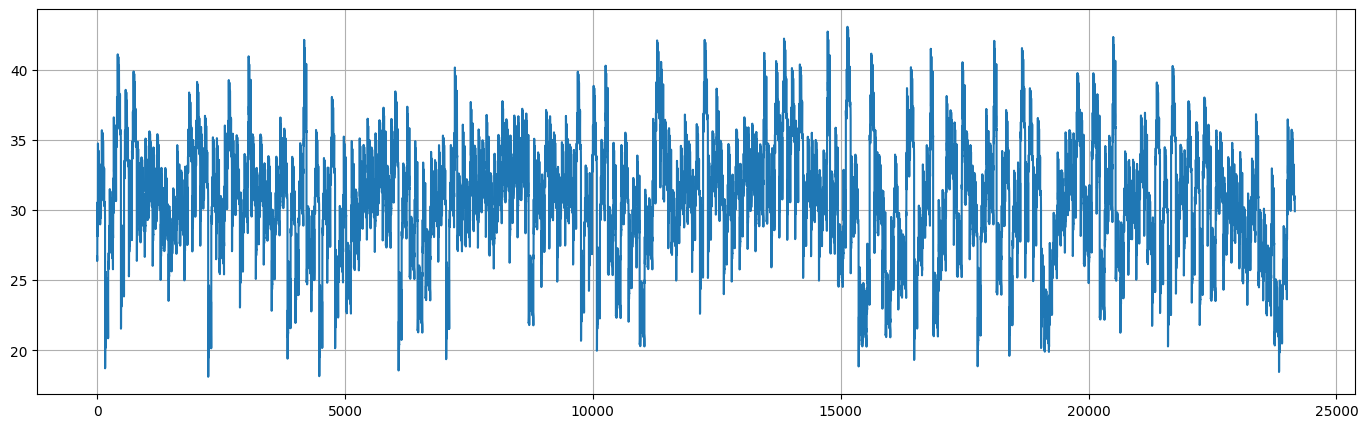

In [4]:
plt.figure(figsize=(17, 5))
plt.plot(df.time, df.pressure)
plt.grid()

In [5]:
startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

13.73% dos dados inicio de sopro
16.67% dos dados término de sopro
total: 30.40% (73536 dados)


In [6]:
target = df.loc[(df.start_blow == False) & (df.stop_blow == False)].sample(frac=0.30, random_state=42)
df = df.drop(target.index).reset_index(drop=True)

startCount = (df.start_blow == True).sum() / len(df) * 100
stopCount  = (df.stop_blow == True).sum()  / len(df)  * 100
total = int((startCount + stopCount) * len(df) / 100)

print(f'{startCount:.2f}% dos dados inicio de sopro')
print(f'{stopCount:.2f}% dos dados término de sopro')
print(f'total: {startCount + stopCount:.2f}% ({total} dados)')

17.36% dos dados inicio de sopro
21.07% dos dados término de sopro
total: 38.42% (73537 dados)


# SEPARAÇÃO DOS DADOS
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [7]:
def getStates(df, key, var='y', n=10):
    table = df.copy() 
    table[f'{var}n[0]'] = table[key]

    for i in range(1, n):
        table[f'{var}n[{i}]'] = table[key].shift(i)

    table.fillna(0, inplace=True)
    columns = [f'{var}n[0]'] + [f'{var}n[{i}]' for i in range(1, n)]
    return table[columns]


def getTrainData(df, outVar='y', size=5):
    states = getStates(df, 'ratio', outVar, size)
    mean   = df[['mean']]
    return pd.concat([mean, states], axis=1)


size  = 30
xData = getTrainData(df, 'Y', size)
xData.head(10)

,mean,Yn[0],Yn[1],Yn[2],Yn[3],Yn[4],Yn[5],Yn[6],Yn[7],Yn[8],...,Yn[20],Yn[21],Yn[22],Yn[23],Yn[24],Yn[25],Yn[26],Yn[27],Yn[28],Yn[29]
0,27.086845,-0.46854,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,27.112318,-0.55043,-0.46854,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,27.110531,-0.59876,-0.55043,-0.46854,0.00000,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,27.087694,-0.61955,-0.59876,-0.55043,-0.46854,0.00000,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,27.049210,-0.61773,-0.61955,-0.59876,-0.55043,-0.46854,0.00000,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,26.943374,-0.56171,-0.61773,-0.61955,-0.59876,-0.55043,-0.46854,0.00000,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,26.883491,-0.51357,-0.56171,-0.61773,-0.61955,-0.59876,-0.55043,-0.46854,0.00000,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,26.822949,-0.45669,-0.51357,-0.56171,-0.61773,-0.61955,-0.59876,-0.55043,-0.46854,0.00000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,26.763934,-0.39572,-0.45669,-0.51357,-0.56171,-0.61773,-0.61955,-0.59876,-0.55043,-0.46854,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,26.707986,-0.33469,-0.39572,-0.45669,-0.51357,-0.56171,-0.61773,-0.61955,-0.59876,-0.55043,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
is_blowing = False

def isBlowing(startBlow, stopBlow):
    global is_blowing

    if startBlow:
        is_blowing = True

    if stopBlow:
        is_blowing = False

    return is_blowing

# MODELO LOGISTIC REGRESSION
As funções abaixo são responsáveis para obter os dados de treino (a partir das suas $n$ entradas anteriores) e criar o modelo de regressão logística para os dados de treino e encontrar a precisão comparando com os dados de teste

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

import seaborn as sns
import random

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [10]:
def getModel(xData, yData, trainSize=0.20):
    xTreino, xTeste, yTreino, yTeste = train_test_split(xData, yData, test_size=trainSize)
    #model = LogisticRegression(class_weight='balanced')
    model = LogisticRegression()
    model.fit(xTreino, yTreino)
    return model

def plotModel(yTest, yModel, yNames, title=''):
    confusionMatrix = confusion_matrix(yTest, yModel)
    score = accuracy_score(yTest, yModel)

    plt.figure(figsize=(10, 5))
    sns.heatmap(confusionMatrix, annot=True, fmt="d", cmap="Blues", xticklabels=yNames, yticklabels=yNames)
    plt.xlabel('Predicted Label'), plt.ylabel('True Label')
    plt.title(f'Precisão do Modelo: {title} {score*100:.2f}%')
    plt.show()

In [11]:
def getBestModel(df, timeout=5):
    global is_blowing
    bestModel  = {'start': None, 'stop': None, 'score': 0.00}
    startTime  = time.time()
    xData = getTrainData(df, 'Y', size)
    i = 0
    
    while time.time() - startTime < timeout:
        trainSize = random.uniform(0.20, 0.55)
        startBlowModel = getModel(xData, df.start_blow, trainSize)
        stopBlowModel  = getModel(xData, df.stop_blow, trainSize)

        yStart = startBlowModel.predict(xData)
        yStop  = stopBlowModel.predict(xData)

        is_blowing = False
        yBlow = [isBlowing(start, stop) for start, stop in zip(yStart, yStop)] 
        score = accuracy_score(df.blowing, yBlow)

        if score > bestModel['score']:
            print(f'score update: {score*100:.2f}% | train size: {trainSize:.2f} | i = {i+1}')
            bestModel = {'start': startBlowModel, 'stop': stopBlowModel, 'score': score}
        
        if score == 1.0:
            break

        i = i + 1
        
    return bestModel


model = getBestModel(df, timeout=10)
startBlowModel = model['start']
stopBlowModel  = model['stop']

score update: 96.05% | train size: 0.46 | i = 1
score update: 96.76% | train size: 0.27 | i = 3


[False  True]


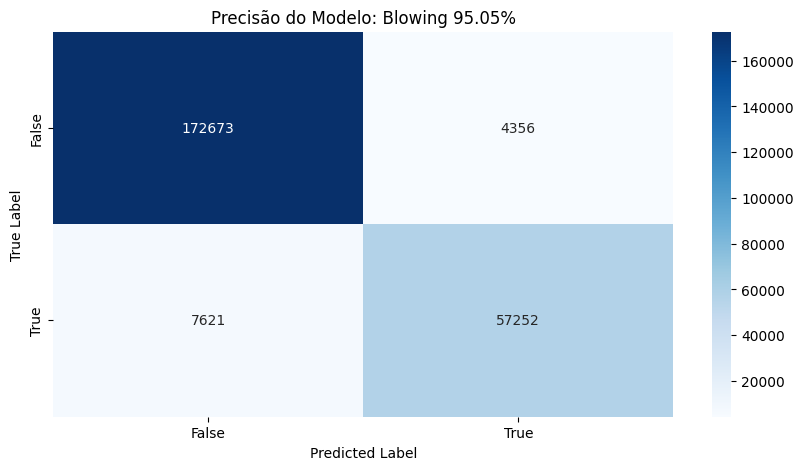

In [13]:
df = pd.read_csv('../DataBase.csv')
xData   = getTrainData(df, 'Y', size)
classes = startBlowModel.classes_
print(classes)

df['start_blow_pred'] = startBlowModel.predict(xData)
df['stop_blow_pred']  = stopBlowModel.predict(xData)
df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
plotModel(df.prediction, df.blowing, classes, 'Blowing')

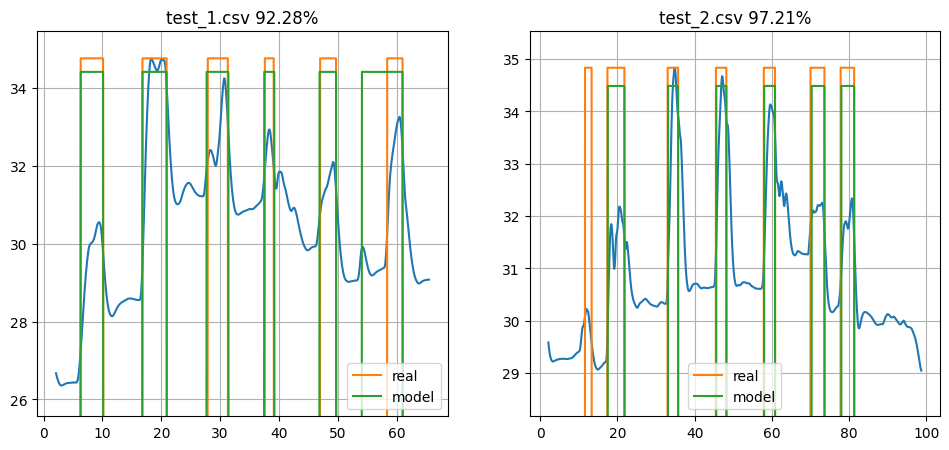

In [14]:
numRows = len(files) // 3 + 1
plt.figure(figsize=(18, 5*numRows))

for i, filePath in enumerate(files):
    df = pd.read_csv(filePath)
    xData = getTrainData(df, 'Y', size)
    name  = filePath.split('\\')[-1]
    
    is_blowing = False
    df['start_blow_pred'] = startBlowModel.predict(xData)
    df['stop_blow_pred']  = stopBlowModel.predict(xData)
    df['prediction']      = df.apply(lambda row: isBlowing(row.start_blow_pred, row.stop_blow_pred), axis=1)
    score = accuracy_score(df.blowing, df.prediction)

    plt.subplot(numRows, 3, i+1)
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.prediction * 0.99 * max(df.pressure), label='model')
    plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
    plt.legend(), plt.grid(), plt.title(f'{name} {score*100:.2f}%')

# IMPLEMENTANDO O MODELO
Para implementar digitalmente em um arduino, o modelo LogisticRegression obedece a seguinte fórmula:
$$p = \frac{1}{1 + e^{-(\omega_0 + \omega_1 x_1 + \omega_2 x_2 + ....)}}$$

In [15]:
startBlowModel.feature_names_in_

array(['mean', 'Yn[0]', 'Yn[1]', 'Yn[2]', 'Yn[3]', 'Yn[4]', 'Yn[5]',
       'Yn[6]', 'Yn[7]', 'Yn[8]', 'Yn[9]', 'Yn[10]', 'Yn[11]', 'Yn[12]',
       'Yn[13]', 'Yn[14]', 'Yn[15]', 'Yn[16]', 'Yn[17]', 'Yn[18]',
       'Yn[19]', 'Yn[20]', 'Yn[21]', 'Yn[22]', 'Yn[23]', 'Yn[24]',
       'Yn[25]', 'Yn[26]', 'Yn[27]', 'Yn[28]', 'Yn[29]'], dtype=object)

In [16]:
startBlowModel.coef_[0]

array([ 0.04723678, 10.63294664,  0.73701931, -1.95029341, -0.53135361,
        1.40877435,  1.92809505,  1.16584185,  0.13400706, -1.02769668,
       -1.2562929 , -1.10241386, -0.62566857,  0.06184705,  0.5435532 ,
        1.05386678,  0.8360823 , -0.30782459, -0.73054946, -0.79162042,
       -0.41369076,  0.15516339,  0.81003475,  0.48949434,  0.53247006,
       -0.07423523, -0.03340942, -0.35395198, -0.52015037, -0.08680064,
        0.92036827])

In [17]:
def getModelString(model):
    coefs = model.coef_[0]
    intercept = model.intercept_[0]
    variables = model.feature_names_in_
    
    text = f'(1.0 / (1.0 + exp(-({intercept:.6f}'

    for i, var in enumerate(variables):
        text += f' + {var}*({coefs[i]:6f})'
    
    return text + '))))'


startBlowModel

LogisticRegression()

In [18]:
startBlowString = getModelString(startBlowModel)
stopBlowString  = getModelString(stopBlowModel)

print(f'const float pBlow    = {startBlowString};')
print(f'const float pNotBlow = {stopBlowString};')
print()

const float pBlow    = (1.0 / (1.0 + exp(-(-7.451511 + mean*(0.047237) + Yn[0]*(10.632947) + Yn[1]*(0.737019) + Yn[2]*(-1.950293) + Yn[3]*(-0.531354) + Yn[4]*(1.408774) + Yn[5]*(1.928095) + Yn[6]*(1.165842) + Yn[7]*(0.134007) + Yn[8]*(-1.027697) + Yn[9]*(-1.256293) + Yn[10]*(-1.102414) + Yn[11]*(-0.625669) + Yn[12]*(0.061847) + Yn[13]*(0.543553) + Yn[14]*(1.053867) + Yn[15]*(0.836082) + Yn[16]*(-0.307825) + Yn[17]*(-0.730549) + Yn[18]*(-0.791620) + Yn[19]*(-0.413691) + Yn[20]*(0.155163) + Yn[21]*(0.810035) + Yn[22]*(0.489494) + Yn[23]*(0.532470) + Yn[24]*(-0.074235) + Yn[25]*(-0.033409) + Yn[26]*(-0.353952) + Yn[27]*(-0.520150) + Yn[28]*(-0.086801) + Yn[29]*(0.920368)))));
const float pNotBlow = (1.0 / (1.0 + exp(-(-16.969145 + mean*(0.110913) + Yn[0]*(-19.796728) + Yn[1]*(-9.309003) + Yn[2]*(-1.474165) + Yn[3]*(1.947950) + Yn[4]*(2.570617) + Yn[5]*(1.383755) + Yn[6]*(-0.298808) + Yn[7]*(-1.100382) + Yn[8]*(-1.444671) + Yn[9]*(-0.886527) + Yn[10]*(-0.408624) + Yn[11]*(-0.673584) + Yn[1

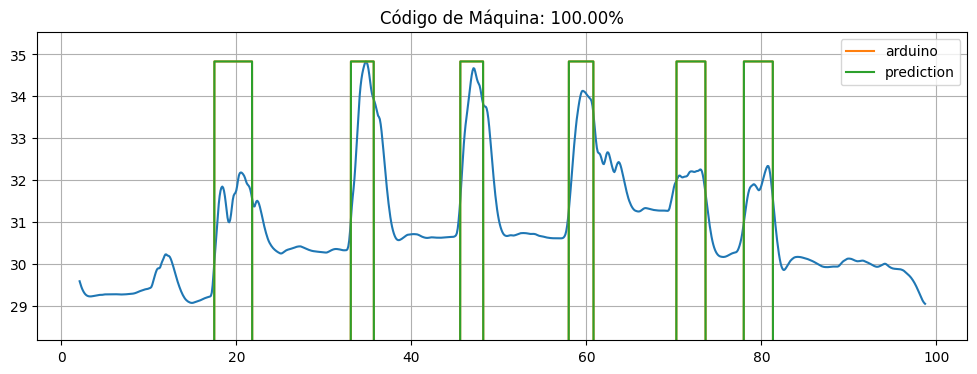

In [19]:
Yn = np.zeros(size)
is_blowing = False

def isBlowing(mean, ratio):
    global size, Yn, is_blowing

    for n in range(size-1, 0, -1):
        Yn[n] = Yn[n-1]
    
    Yn[0] = ratio
    pBlow    = eval(startBlowString)
    pNotBlow = eval(stopBlowString)

    if pBlow > 0.5:
        is_blowing = True
    
    if pNotBlow > 0.5:
        is_blowing = False

    return is_blowing


df['arduino'] = df.apply(lambda row: isBlowing(row['mean'], row['ratio']), axis=1)
score = accuracy_score(df.prediction, df.arduino)
plt.figure(figsize=(12, 4))
plt.title(f'Código de Máquina: {score*100:.2f}%')
plt.plot(df.time, df.pressure)
plt.plot(df.time, df.arduino    * df.pressure.max(), label='arduino')
plt.plot(df.time, df.prediction * df.pressure.max(), label='prediction')
plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
plt.legend()
plt.grid()

../files\test_1.csv


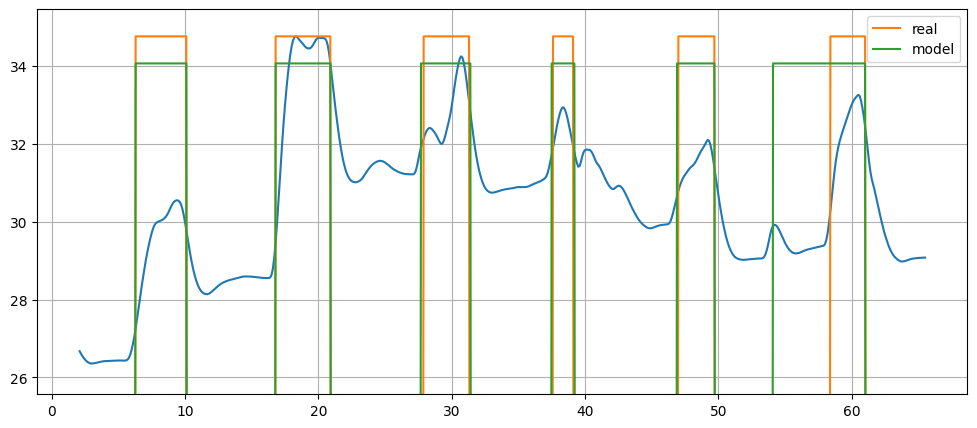

../files\test_2.csv


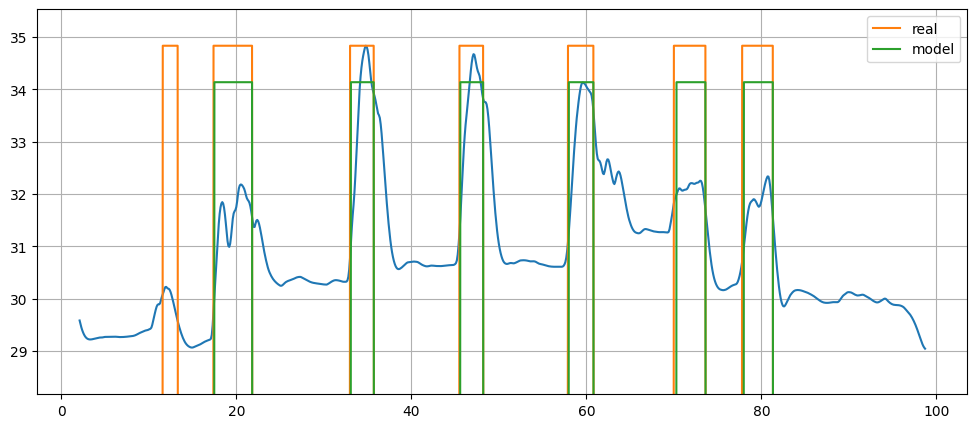

In [20]:
for filePath in files:
    df = pd.read_csv(filePath)
    print(filePath)
    is_blowing = False
    df['arduino'] = df.apply(lambda row: isBlowing(row['mean'], row['ratio']), axis=1)
    plt.figure(figsize=(12, 5))
    plt.plot(df.time, df.pressure)
    plt.plot(df.time, df.blowing * max(df.pressure), label='real')
    plt.plot(df.time, df.arduino * 0.98 * max(df.pressure), label='model')
    plt.ylim(df.pressure.min()*0.97, df.pressure.max()*1.02)
    plt.legend(), plt.grid(), plt.show()